In [1]:
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.colors import Normalize
import re
plt.rcParams["svg.fonttype"] = "none"
from scipy.stats import chi2_contingency, ttest_ind, mannwhitneyu
import itertools
from statsmodels.stats.proportion import proportions_ztest
pd.set_option('display.max_columns', None)

In [2]:
uniprot_names_and_weights = pd.read_csv('Data/uniprot_reviewed_multiple_data/uniprotkb_taxonomy_id_10090_AND_reviewe_2024_11_26.tsv', sep='\t')

uniprot_names_and_weights = uniprot_names_and_weights.rename(columns={"Mass": "Mass (Da)"})

def calculate_disordered_ratio(df):
    print('Disordered')
    def parse_disordered_length(row):
        region_info = row['Region']
        if pd.isna(region_info) or not isinstance(region_info, str):
            return 0
        ranges = re.findall(r'(\d+)\.\.(\d+); /note="Disordered"', region_info)
        total_length = sum(int(end) - int(start) + 1 for start, end in ranges)
        return total_length
    
    df['Disordered Ratio'] = df.apply(lambda row: parse_disordered_length(row) / row['Length'] if row['Length'] != 0 else 0, axis=1)
    return df

uniprot_data_with_mass_and_longest = calculate_disordered_ratio(uniprot_names_and_weights)
uniprot_data_with_mass_and_longest

Disordered


,Entry,Reviewed,Entry Name,Protein names,Gene Names,Organism,Length,Region,Compositional bias,Domain [CC],Domain [FT],Coiled coil,Motif,Post-translational modification,Signal peptide,Transit peptide,Glycosylation,Intramembrane,Subcellular location [CC],Transmembrane,Topological domain,Mass (Da),ComplexPortal,CORUM,BioGRID,DIP,ELM,IntAct,MINT,STRING,Disordered Ratio
0,A0A087WPF7,reviewed,AUTS2_MOUSE,Autism susceptibility gene 2 protein homolog,Auts2 Kiaa0442,Mus musculus (Mouse),1261,"REGION 1..88; /note=""Disordered""; /evidence=""E...","COMPBIAS 45..61; /note=""Polar residues""; /evid...",DOMAIN: The Pro-rich region is important for t...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SUBCELLULAR LOCATION: Nucleus {ECO:0000269|Pub...,NaN,NaN,138920,NaN,NaN,NaN,NaN,NaN,A0A087WPF7; 23.;,A0A087WPF7;,10090.ENSMUSP00000139759;,0.665345
1,A0A088MLT8,reviewed,IQIP1_MOUSE,IQCJ-SCHIP1 readthrough transcript protein,Iqcj-Schip1 Iqschfp Schip1,Mus musculus (Mouse),559,"REGION 64..141; /note=""Disordered""; /evidence=...","COMPBIAS 69..97; /note=""Polar residues""; /evid...",NaN,"DOMAIN 47..67; /note=""IQ""","COILED 496..530; /evidence=""ECO:0000255""",NaN,NaN,NaN,NaN,NaN,NaN,"SUBCELLULAR LOCATION: Cell projection, axon {E...",NaN,NaN,61917,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10090.ENSMUSP00000138212;,0.502683
2,A0A0B4J1F4,reviewed,ARRD4_MOUSE,Arrestin domain-containing protein 4,Arrdc4,Mus musculus (Mouse),415,NaN,NaN,NaN,NaN,NaN,"MOTIF 347..350; /note=""PPxY motif 1""; /evidenc...",NaN,NaN,NaN,NaN,NaN,SUBCELLULAR LOCATION: Early endosome {ECO:0000...,NaN,NaN,44970,NaN,NaN,NaN,NaN,NaN,A0A0B4J1F4; 1.;,NaN,10090.ENSMUSP00000044578;,0.000000
3,A0A0B4J1G0,reviewed,FCG3A_MOUSE,Low affinity immunoglobulin gamma Fc region re...,Fcgr4 Fcgr3a,Mus musculus (Mouse),249,NaN,NaN,NaN,"DOMAIN 22..102; /note=""Ig-like C2-type 1""; /ev...",NaN,NaN,PTM: N-glycosylated. {ECO:0000269|PubMed:16039...,"SIGNAL 1..20; /evidence=""ECO:0000255""",NaN,"CARBOHYD 62; /note=""N-linked (GlcNAc...) aspar...",NaN,SUBCELLULAR LOCATION: Cell membrane {ECO:00002...,"TRANSMEM 204..224; /note=""Helical""; /evidence=...","TOPO_DOM 21..203; /note=""Extracellular""; /evid...",28398,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10090.ENSMUSP00000077873;,0.000000
4,A0A0B4J1N3,reviewed,GP15L_MOUSE,Protein GPR15LG (Protein GPR15 ligand) (Protei...,Gpr15lg Gpr15l,Mus musculus (Mouse),78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"SIGNAL 1..24; /evidence=""ECO:0000250|UniProtKB...",NaN,NaN,NaN,SUBCELLULAR LOCATION: Secreted {ECO:0000250|Un...,NaN,NaN,8899,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10090.ENSMUSP00000136426;,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17223,Q9JJR6,reviewed,CK016_MOUSE,Uncharacterized protein C11orf16 homolog,D7h11orf16,Mus musculus (Mouse),402,"REGION 332..402; /note=""Disordered""; /evidence...","COMPBIAS 363..380; /note=""Polar residues""; /ev...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44484,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.176617
17224,Q9JJR9,reviewed,NRIP3_MOUSE,Nuclear receptor-interacting protein 3,Nrip3 D7H11orf14,Mus musculus (Mouse),240,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26879,NaN,NaN,219504; 27.;,NaN,NaN,Q9JJR9; 27.;,NaN,10090.ENSMUSP00000033331;,0.000000
17225,Q9WUQ7,reviewed,DEXI_MOUSE,Dexamethasone-induced protein (Protein MYLE),Dexi Myle,Mus musculus (Mouse),95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10402,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10090.ENSMUSP00000139108;,0.000000
17226,Q9WVB6,reviewed,LENEP_MOUSE,Lens epithelial cell protein LEP503,Lenep Lep503,Mus musculus (Mouse),61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6923,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10090.ENSMUSP00000052968;,0.000000


In [3]:
picnic_df = pd.read_csv('Data/picnic_data/PICNIC-10090-data.csv')
picnic_df = picnic_df[(picnic_df['Genes'].apply(lambda x: isinstance(x, str)))]

uniprot_data_with_mass_and_longest_and_picnic = pd.merge(uniprot_data_with_mass_and_longest, picnic_df, left_on='Gene Names', right_on='Genes', how='left')
for column in uniprot_data_with_mass_and_longest_and_picnic.columns:
    print(column)   

Entry
Reviewed
Entry Name
Protein names
Gene Names
Organism_x
Length
Region
Compositional bias
Domain [CC]
Domain [FT]
Coiled coil
Motif
Post-translational modification
Signal peptide
Transit peptide
Glycosylation
Intramembrane
Subcellular location [CC]
Transmembrane
Topological domain
Mass (Da)
ComplexPortal
CORUM
BioGRID
DIP
ELM
IntAct
MINT
STRING
Disordered Ratio
ID
PICNIC score
PICNIC GO score
Uniprot ID
Proteins
Genes
Organism_y
Organism ID
CD-Code included


In [4]:
stress_smoops = pd.read_csv('Analysis/Exploratory/revision/smoops_stress/data/temp_files/stress_smoops_transcripts_seq_collapsed_length_subset.tsv', sep='\t')
stress_smoops["non-smOOPs"] = ~(stress_smoops["stress_smoops"] & stress_smoops["nostress_smoops"])

stress_smoops_set = set(stress_smoops[stress_smoops["stress_smoops"]]['gene_name'])
no_stress_smoops_set = set(stress_smoops[stress_smoops["nostress_smoops"]]['gene_name'])

non_smoops_set = set(stress_smoops[stress_smoops["non-smOOPs"]]['gene_name'])


In [5]:
def mark_genes_in_set(df, gene_set, gene_set_name):

    def is_gene_in_set(gene_names_str):
        gene_names_str = str(gene_names_str)
        gene_names = gene_names_str.split()
        return any(gene in gene_set for gene in gene_names)
    
    df[gene_set_name] = df['Gene Names'].apply(is_gene_in_set)
    
    return df

list_of_sets = [stress_smoops_set, no_stress_smoops_set, non_smoops_set]
list_of_set_names = ['no_stress_smoops_set','stress_smoops_set', 'non-smOOPs']

for gene_set, gene_set_name in zip(list_of_sets, list_of_set_names):
    uniprot_data_with_mass_and_longest_and_picnic = mark_genes_in_set(uniprot_data_with_mass_and_longest_and_picnic, gene_set, gene_set_name)
    print(gene_set_name, len(uniprot_data_with_mass_and_longest_and_picnic[uniprot_data_with_mass_and_longest_and_picnic[gene_set_name] == True]))
    
for set_name in list_of_set_names:
    print(set_name, uniprot_data_with_mass_and_longest_and_picnic[set_name].value_counts())

no_stress_smoops_set 415
stress_smoops_set 312
non-smOOPs 11618
no_stress_smoops_set no_stress_smoops_set
False    16814
True       415
Name: count, dtype: int64
stress_smoops_set stress_smoops_set
False    16917
True       312
Name: count, dtype: int64
non-smOOPs non-smOOPs
True     11618
False     5611
Name: count, dtype: int64


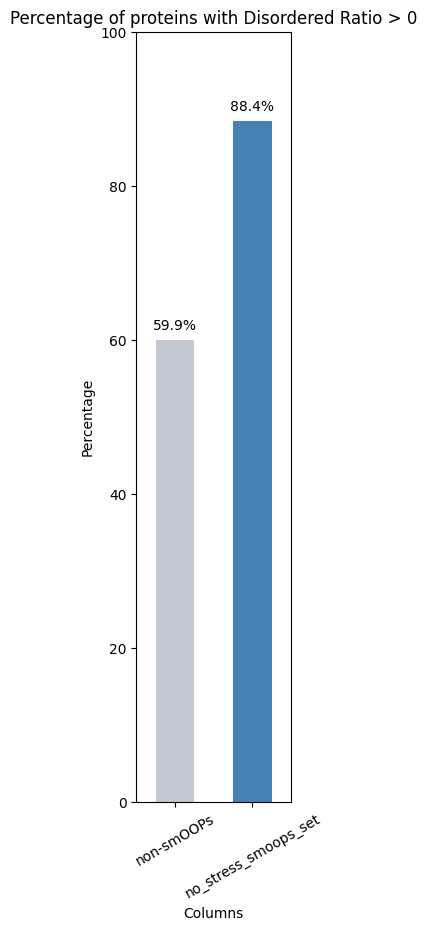

Comparison non-smOOPs vs no_stress_smoops_set: Z-stat = -11.692176587872616, p-value = 1.3975827867318565e-31
Chi-square statistic: 135.5125, p-value: 0.0000
Significant difference in disorder percentages between groups.


In [16]:
def plot_true_percentage(df, true_columns, value_column):
    percentages = []
    for col in true_columns:
        true_values = df[df[col] == True]
        percentage = (true_values[value_column] > 0).mean()*100
        percentages.append(percentage)
        
    plt.figure(figsize=(2, 10))
    bars = plt.bar(true_columns, percentages, color=['#C3C9D3', '#4682B4', '#fc8d62'], width=0.5)
    plt.xlabel("Columns")
    plt.ylabel("Percentage")
    plt.title(f"Percentage of proteins with {value_column} > 0")
    
    for bar, percentage in zip(bars, percentages):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{percentage:.1f}%', ha='center', va='bottom')
    plt.xticks(rotation=30)
    
    plt.ylim(0, 100)
    plt.xlim(-0.5, len(true_columns)-0.5)
    plt.show()

def compare_z_test(df, true_columns, value_column):
    results = {}

    for col1, col2 in itertools.combinations(true_columns, 2):
        group1 = df[df[col1] == True]
        group2 = df[df[col2] == True]

        count = [(group1[value_column] > 0).sum(), (group2[value_column] > 0).sum()]
        nobs = [len(group1), len(group2)]

        z_stat, p_value = proportions_ztest(count, nobs)
        results[(col1, col2)] = p_value
        print(f"Comparison {col1} vs {col2}: Z-stat = {z_stat}, p-value = {p_value}")

    return results

def compare_chi_square(df, true_columns, value_column):
    contingency_table = []

    for col in true_columns:
        group = df[df[col] == True]
        disorder = (group[value_column] > 0).sum()
        non_disorder = len(group) - disorder
        contingency_table.append([disorder, non_disorder])

    chi2, p_value, _, _ = chi2_contingency(contingency_table)
    
    print(f"Chi-square statistic: {chi2:.4f}, p-value: {p_value:.4f}")

    if p_value < 0.05:
        print("Significant difference in disorder percentages between groups.")
    else:
        print("No significant difference between groups.")

features = ["Disordered Ratio",
            ]

for feature in features:
    plot_true_percentage(uniprot_data_with_mass_and_longest_and_picnic, ["non-smOOPs", 'no_stress_smoops_set'], feature)


compare_z_test(uniprot_data_with_mass_and_longest_and_picnic, ["non-smOOPs", 'no_stress_smoops_set'], "Disordered Ratio")
compare_chi_square(uniprot_data_with_mass_and_longest_and_picnic, ["non-smOOPs", 'no_stress_smoops_set'], "Disordered Ratio")

All data points:  17229
Data points with non-NaN values:  17229
non-smOOPs: 11618 data points, mean = 0.13
no_stress_smoops_set: 415 data points, mean = 0.25
non-smOOPs vs no_stress_smoops_set: p-value = 2.778954028972677e-26


/tmp/ipykernel_892818/310410956.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Condition', y=column, data=melted_data, palette=hex_palette, width=0.6, zorder=2)
/tmp/ipykernel_892818/310410956.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['non-smOOPs', 'no_stress_smoops_set'])


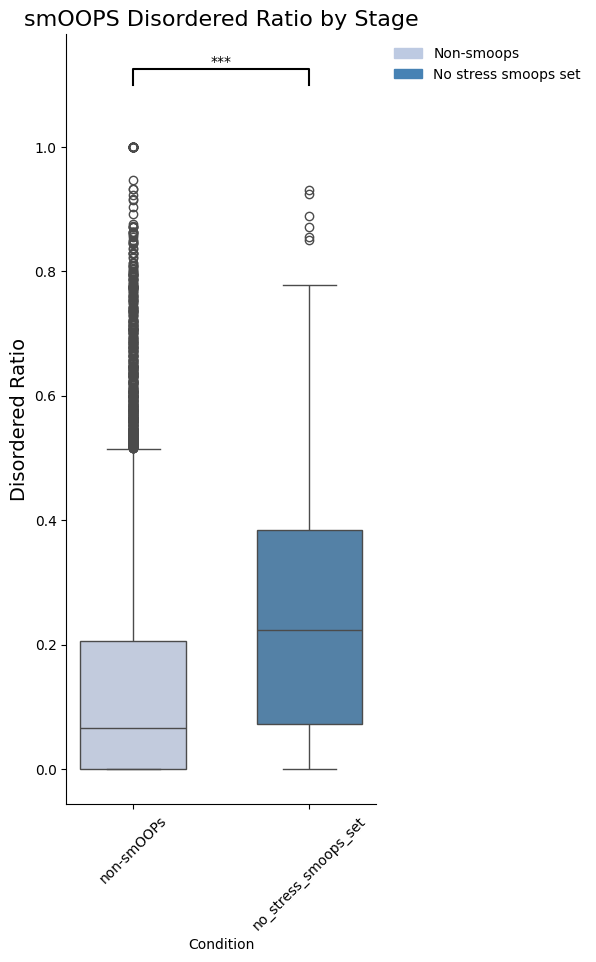

All data points:  17229
Data points with non-NaN values:  17229
non-smOOPs: 11618 data points, mean = 4.71
no_stress_smoops_set: 415 data points, mean = 5.09
non-smOOPs vs no_stress_smoops_set: p-value = 7.437738836405445e-84


/tmp/ipykernel_892818/310410956.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Condition', y=column, data=melted_data, palette=hex_palette, width=0.6, zorder=2)
/tmp/ipykernel_892818/310410956.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['non-smOOPs', 'no_stress_smoops_set'])


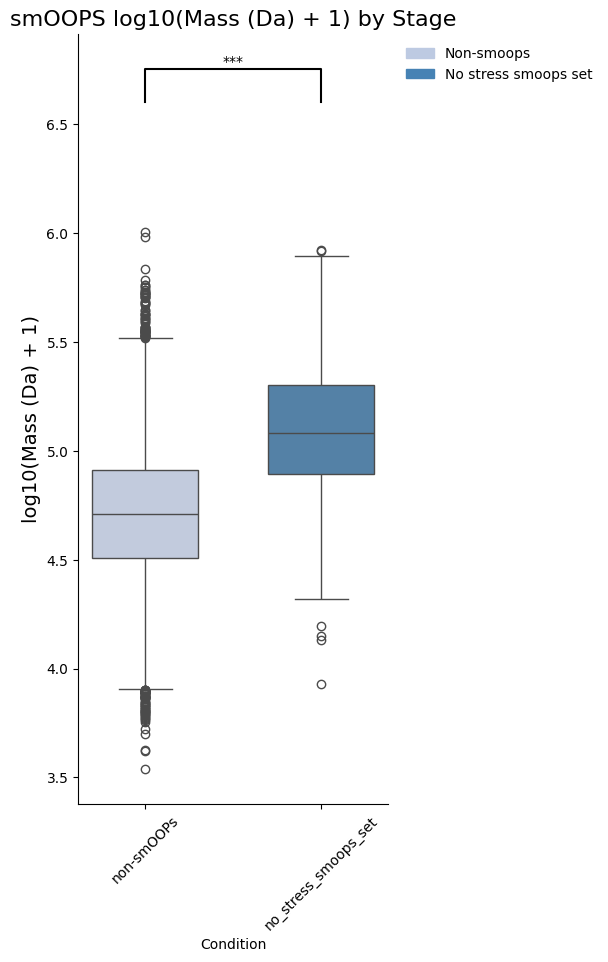

All data points:  17229
Data points with non-NaN values:  16431
non-smOOPs: 11369 data points, mean = 0.50
no_stress_smoops_set: 356 data points, mean = 0.59
non-smOOPs vs no_stress_smoops_set: p-value = 1.1265392942972364e-11


/tmp/ipykernel_892818/310410956.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Condition', y=column, data=melted_data, palette=hex_palette, width=0.6, zorder=2)
/tmp/ipykernel_892818/310410956.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['non-smOOPs', 'no_stress_smoops_set'])


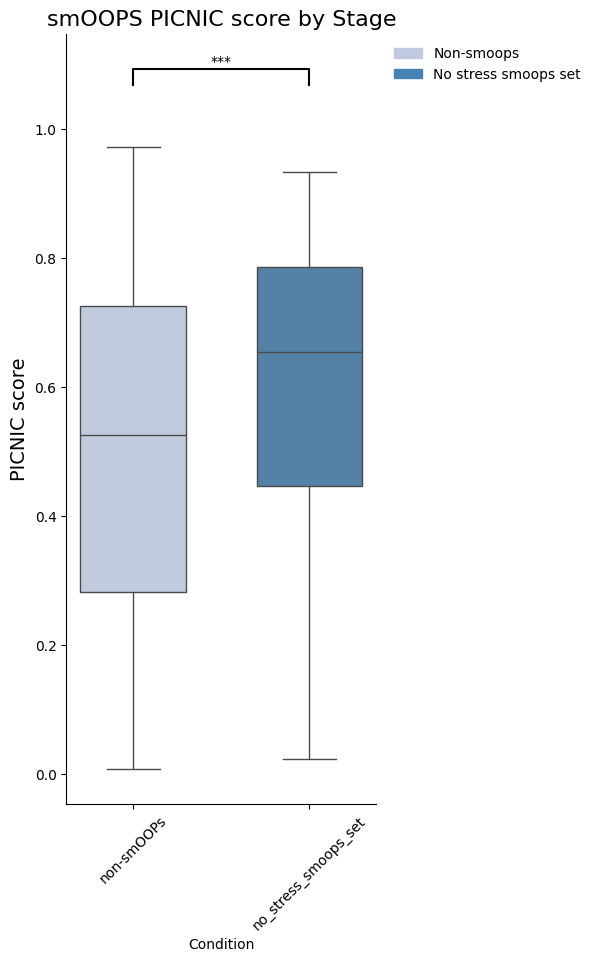

In [19]:
def plot_boxplot(df, column, log=False, stat_test = 'ttest'):
    try:
        print("All data points: ", len(df))
        df = df.copy()
        df = df[df[column].notna()]
        df[column] = df[column].astype(float)

        if log:
            df[f'log10({column} + 1)'] = np.log10(df[column]+ 1)
            column = f'log10({column} + 1)'
            
        print("Data points with non-NaN values: ", len(df))

        conditions = ['non-smOOPs', 'no_stress_smoops_set']
        filtered_data = pd.DataFrame({
            condition: df[df[condition] == True][column] for condition in conditions
        })
        melted_data = filtered_data.melt(var_name='Condition', value_name=column)
        
        
        comparisons = [('non-smOOPs', 'no_stress_smoops_set')]
        results = []
        for test_a, test_b in comparisons:
            test_a_data = filtered_data[test_a].dropna().to_list()
            test_b_data = filtered_data[test_b].dropna().to_list()
            print(f'{test_a}: {len(test_a_data)} data points, mean = {np.mean(test_a_data):.2f}')
            print(f'{test_b}: {len(test_b_data)} data points, mean = {np.mean(test_b_data):.2f}')
            if stat_test == 'ttest':
                stat, p_val = ttest_ind(test_a_data, test_b_data, equal_var=False)
            elif stat_test == 'mannwhitneyu':
                stat, p_val = mannwhitneyu(test_a_data, test_b_data)
            print(f'{test_a} vs {test_b}: p-value = {p_val}')
            results.append((test_a, test_b, p_val))

        hex_palette = {'non-smOOPs': '#bdcae2', 'no_stress_smoops_set': '#4682B4'}
        
        plt.figure(figsize=(4, 10))

        ax = sns.boxplot(x='Condition', y=column, data=melted_data, palette=hex_palette, width=0.6, zorder=2)    
        
        y_max = melted_data[column].max() * 1.10
        
        y_step = y_max / 11 

        for idx, (test_a, test_b, p_val) in enumerate(results):
            x1, x2 = conditions.index(test_a), conditions.index(test_b)
            y, h = y_max + idx * y_step, y_step / 4
            ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c='black')
            significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "ns"
            ax.text((x1 + x2) * 0.5, y + h, significance, ha='center', va='bottom', color='black')
        
        plt.title(f'smOOPS {column} by Stage', fontsize=16)
        plt.ylabel(f'{column}', fontsize=14)
        plt.xticks(rotation=45)

        ax.set_xticklabels(['non-smOOPs', 'no_stress_smoops_set'])

        legend_elements = [mpatches.Patch(color=hex_palette[name], label=name.replace('_', ' ').capitalize()) for name in hex_palette]
        plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.7, 1), frameon=False)

        sns.despine()
        plt.show()

    except Exception as e:
        print(e)

features = ["Disordered Ratio",
            "Mass (Da)",
            "PICNIC score"
            ]

for feature in features:
    log = False
    if feature == "Mass (Da)":
        log = True
    if feature == "Mass (Da)" or feature == "PICNIC score":
        stat_test = 'ttest'
    else:
        stat_test = 'mannwhitneyu'
        
    plot_boxplot(uniprot_data_with_mass_and_longest_and_picnic, column=feature, log=log)